In [18]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.container { font-size:18px !important; }</style>"))

import numpy as np 
import matplotlib.pyplot as plt 
import numpy as np
from astropy.io import fits

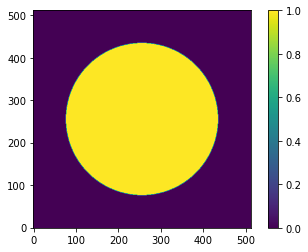

In [19]:
#make the PSF:
N = 512 #number of points for time-dependent
a = 1.0 #total size of the grid, in meters
aperture= np.zeros([N,N]) #array containing the aperture (1 will be where light can enter, zero where it cannot)

x = np.linspace(-a/2.0,a/2.0,N) #x grid
y = np.linspace(-a/2.0,a/2.0,N) #y grid
R = 0.35 #radius of the telescope
 
#make circular aperture
for i in range(0,N):
    for j in range(0,N):
        if ((x[i]**2.0 + y[j]**2.0)**0.5 <= R):
            aperture[i,j] = 1.0
            
plt.imshow(np.real(aperture),origin='lower') #plot the aprerture
plt.colorbar()
plt.show()

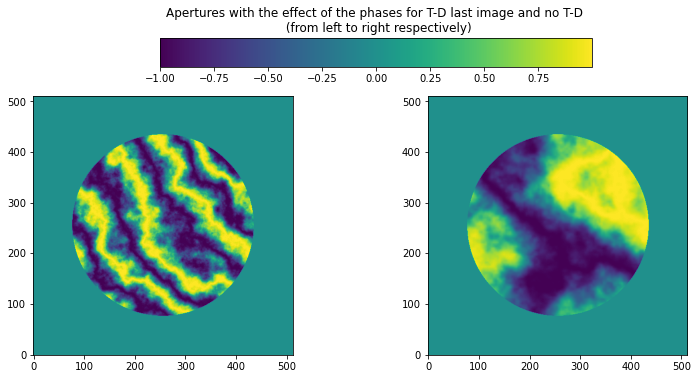

In [20]:
Im= fits.open("pscreen-512x512x100.fits")[0].data
phase = fits.open("phase.fits")[0].data
#add phase information to the aperture
TD_aperture=aperture * np.exp(1.j*Im) #Aperture for time-dependent (T-D)
aperture=aperture*np.exp(1.j*phase[2048//2-N//2:2048//2+N//2,2048//2-N//2:2048//2+N//2]) #Aperture like Handson_diff notebook

plt.subplot(121)
plt.imshow(np.real(TD_aperture[99]),origin='lower') #plot the aprerture of the last image
plt.subplot(122)
plt.imshow(np.real(aperture),origin='lower')
plt.subplots_adjust(bottom=1, right=1.8, top=1.9)
cax = plt.axes([0.5,2,1,0.1])
plt.title("Apertures with the effect of the phases for T-D last image and no T-D \n (from left to right respectively)")
plt.colorbar(orientation='horizontal',cax=cax)
plt.show()

C:\Users\asus\anaconda3\lib\site-packages\ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


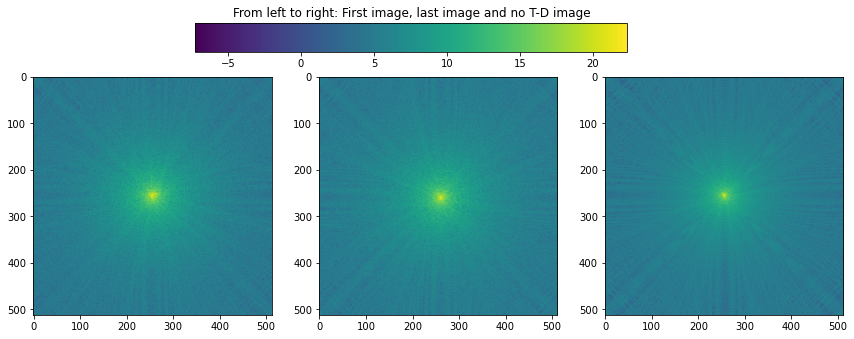

In [21]:
# Now, from the (complex) aperture, we calculate the FFT:
TD_aperture_fft=np.zeros([100,N,N],dtype=complex) #Without dtype=complex, the program neglect the imaginary part, wich is diferent of 0j

TD_PSF=np.zeros([100,N,N],dtype=complex)

TD_PSF_R=np.zeros([100,N,N])
TD_Prom_PSF_R=np.zeros([N,N])

#For T-D:
for i in range(100):
    TD_aperture_fft[i] =np.fft.fft2(TD_aperture[i])
    TD_PSF[i] = np.abs(TD_aperture_fft[i])
    TD_PSF[i] = (TD_PSF[i]**2.0)
    TD_PSF_R[i]=(TD_PSF[i]) #Neglecting the imaginary part, wich is 0j for all the components
    # we need to rearange this:
    TD_PSF_R[i] = np.fft.fftshift(TD_PSF_R[i],axes=(0,1))
    TD_Prom_PSF_R+=TD_PSF_R[i]/len(TD_PSF_R[i])

#For no T-D:
aperture_fft = np.fft.fft2(aperture)
PSF = np.abs(aperture_fft)
PSF = PSF**2.0
# we need to rearange this:
PSF = np.fft.fftshift(PSF,axes=(0,1))

# we plot psf in the log scale
plt.subplot(131) # plt.subplot(r,c,i) where r=row, c=column, i=index or number of image
plt.imshow(np.log(TD_PSF_R[0][:,:])) #we are only going to be interested in the innermost part of the PSF
plt.subplot(132)
plt.imshow(np.log(TD_PSF_R[99][:,:]))
plt.subplot(133)
plt.imshow(np.log(PSF[:,:]))
plt.subplots_adjust(bottom=1, right=2, top=2) #Position and size of the images
cax = plt.axes([0.5,2,1,0.1]) #Position and size of the colorbar
plt.title("From left to right: First image, last image and no T-D image")
plt.colorbar(orientation='horizontal',cax=cax)
plt.show()

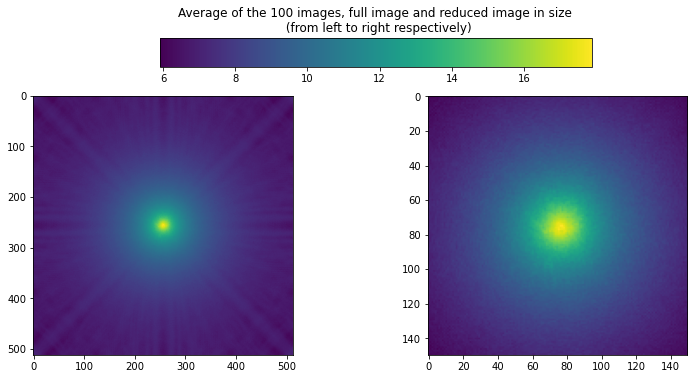

In [22]:
plt.subplot(121)
plt.imshow(np.log(TD_Prom_PSF_R[:,:])) #Full range of image
plt.subplot(122)
plt.imshow(np.log(TD_Prom_PSF_R[180:330,180:330]))
plt.subplots_adjust(bottom=1, right=1.8, top=1.9)
cax = plt.axes([0.5,2,1,0.1])
plt.title("Average of the 100 images, full image and reduced image in size \n (from left to right respectively)")
plt.colorbar(orientation='horizontal',cax=cax)
plt.show()

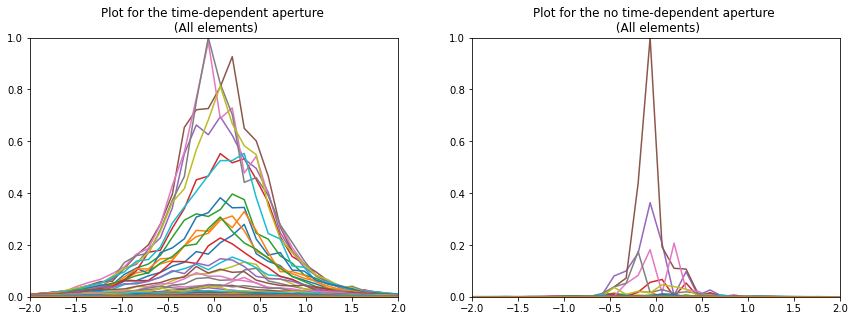

In [23]:
# At the moment, our x (and y) scales for the PSF are in pixels, so to speak. Realistically they should be in wave numbers
# Then we need to transform these wavenumbers into angles. We don't have time to clarify this but transformation is done in
# the following way:
x_step = a / N #step of the original image
xf = np.linspace(-1.0/(2.0*x_step),1.0/(2.0*x_step), N) #space of spatial frequencies
llambda = 630E-9 # wavelength we are observing at
theta = xf*llambda * 206265 #transform the spatial frequencies to angles
TD_norm = np.amax(TD_Prom_PSF_R) # we want to normalize the psf with respect to maximum first: 
TD_Prom_PSF_R /= TD_norm
norm = np.amax(PSF)
PSF /= norm
plt.subplot(121)
plt.plot(theta,TD_Prom_PSF_R) #plot of all elements
plt.xlim([-2,2])
plt.ylim([0,1])
plt.title("Plot for the time-dependent aperture \n (All elements)")
plt.subplot(122)
plt.plot(theta,PSF)
plt.xlim([-2,2])
plt.ylim([0,1])
plt.subplots_adjust(bottom=1, right=2, top=1.9)
plt.title("Plot for the no time-dependent aperture \n (All elements)")
plt.show()

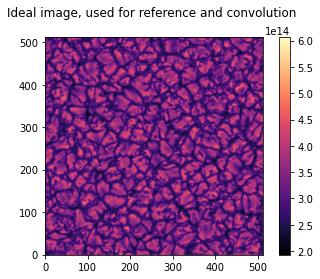

In [24]:
variations_r0s = fits.open("r0s.fits")[0].data
# load the image from file
image = fits.open("synth_sun.fits")[0].data
plt.imshow(image,origin='lower',cmap='magma')
plt.title("Ideal image, used for reference and convolution \n")
plt.colorbar()
plt.show()

In [25]:
# now finally, convolve
from scipy.signal import convolve2d

# we have to normalize again so that the surface of the psf is one 
#T-D

TD_Prom_PSF_R /= np.sum(TD_Prom_PSF_R)

TD_image_smeared = convolve2d(image,TD_Prom_PSF_R,mode='same',boundary='symm') 
#No T_D
PSF /= np.sum(PSF)
image_smeared = convolve2d(image,PSF,mode='same',boundary='symm') 

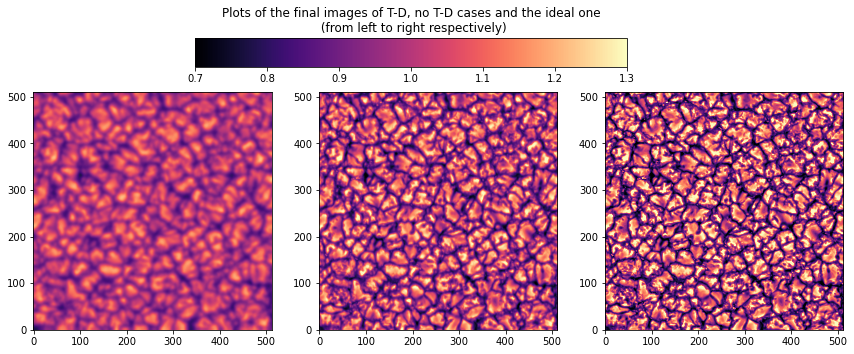

In [29]:
mean = np.mean(image)
image /= mean
TD_image_smeared /=mean
Image_smeared=image_smeared
Image_smeared /=mean

plt.subplot(131)
plt.imshow(TD_image_smeared,vmin=0.7,vmax=1.3,origin='lower',cmap='magma')
plt.subplot(132)
plt.imshow(Image_smeared,vmin=0.7,vmax=1.3,origin='lower',cmap='magma')
plt.subplot(133)
plt.imshow(image,vmin=0.7,vmax=1.3,origin='lower',cmap='magma')

plt.subplots_adjust(bottom=1, right=2, top=2) #Position and size of the images
cax = plt.axes([0.5,2,1,0.1]) #Position and size of the colorbar
plt.title("Plots of the final images of T-D, no T-D cases and the ideal one\n (from left to right respectively)")
plt.colorbar(orientation='horizontal',cax=cax)
plt.show()

In [9]:
print(variations_r0s)

[0.1        0.1        0.1        0.1        0.1        0.1
 0.10000001 0.10000003 0.10000007 0.10000017 0.10000041 0.10000093
 0.10000206 0.10000443 0.10000928 0.10001891 0.10003743 0.10007204
 0.10013478 0.10024509 0.10043325 0.10074444 0.10124342 0.10201881
 0.10318614 0.10488794 0.10728916 0.11056626 0.11488866 0.12039299
 0.1271517  0.1351401  0.14420774 0.15406062 0.16426113 0.17424981
 0.18338983 0.19103034 0.19658005 0.19957934 0.19975806 0.19706812
 0.19168447 0.18397419 0.17443988 0.1636483  0.15215784 0.14045785
 0.12892943 0.11783229 0.10731663 0.09745396 0.08827765 0.07982272
 0.07215584 0.06538911 0.05967546 0.05518758 0.052086   0.05048388
 0.0504168  0.05182416 0.05454621 0.05833716 0.06289139 0.06787748
 0.07297355 0.07789793 0.08243077 0.08642451 0.08980366 0.09255574
 0.0947169  0.09635543 0.09755604 0.09840693 0.0989906  0.09937829
 0.09962778 0.09978338 0.09987745 0.09993261 0.09996398 0.09998128
 0.09999055 0.09999536 0.09999778 0.09999897 0.09999954 0.0999998
 0.

# Because the diameter or our telescope is larger than any of the r0 parameters above, it means that the image resolution is determined primarily by the atmosphere and is independent of telescope diameter.

# For the part 2, we are gonna use the results of the no T-D part, like Handson_diff notebook 

[[2.59158417e+14 2.54691476e+14 2.52577131e+14 ... 3.00591768e+14
  2.87548316e+14 2.78794738e+14]
 [2.55623407e+14 2.54723607e+14 2.53595454e+14 ... 3.00571693e+14
  2.84067286e+14 2.74606348e+14]
 [2.51153630e+14 2.51819578e+14 2.52335328e+14 ... 2.95182341e+14
  2.79213845e+14 2.69943851e+14]
 ...
 [2.71039316e+14 2.75354832e+14 2.82511879e+14 ... 2.85489297e+14
  2.79593781e+14 2.75413789e+14]
 [2.67357424e+14 2.71338344e+14 2.74231385e+14 ... 2.84493545e+14
  2.77971554e+14 2.73448949e+14]
 [2.67013949e+14 2.67310010e+14 2.66216217e+14 ... 2.86420273e+14
  2.79325926e+14 2.74050133e+14]]
[[4.32382178e-09 1.14365925e-08 1.11648311e-08 ... 9.83371693e-09
  1.12247621e-09 4.57278499e-09]
 [6.19583231e-09 2.59598738e-09 1.28220847e-08 ... 1.12159997e-08
  3.54285834e-09 2.18045408e-09]
 [9.52026453e-09 1.41033698e-08 9.47707064e-09 ... 1.21487525e-08
  7.43998520e-09 8.55804452e-09]
 ...
 [7.92035464e-09 1.44363006e-08 6.62934287e-09 ... 1.07549450e-09
  8.40727508e-09 8.75331142e-09]

C:\Users\asus\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


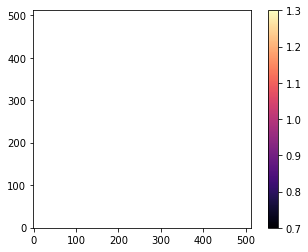

In [27]:
aaperture = np.fft.ifft2(PSF)
reimsmeared=np.fft.ifft2(image_smeared)
Idfds=reimsmeared/aaperture

Ifin = np.fft.fft2(Idfds)
Ifin = np.abs(Ifin)
Ifin= Ifin**2.0
Ifin = np.fft.fftshift(Ifin,axes=(0,1))


norm = np.amax(Ifin) # we want to normalize the psf with respect to maximum first: 
#Ifin /= norm
mean = np.mean(Ifin)
Ifin /= mean
#Ifin /= norm
print(Ifin)
plt.imshow(Ifin,vmin=0.7,vmax=1.3,origin='lower',cmap='magma')
plt.colorbar()
plt.show()

# Despite applying the properties of the Fourier transform and convolution, problems are observed in the final result, perhaps due to some consideration not taken